In [168]:
import numpy as np
import torch
from matplotlib import pyplot as plt
import gpytorch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torch.distributions.kl import kl_divergence
import GaussianProcess

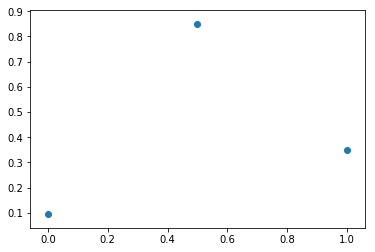

In [169]:
#generates data

num_datapoints = 3

def f(x):
    return np.sin(3*x)

xs = torch.linspace(0, 1, num_datapoints)
ys = f(xs) + torch.distributions.Normal(torch.zeros(num_datapoints), .1).rsample()
plt.scatter(xs, ys)

In [172]:
y_var = 0.1

class encoder(nn.Module):
    def __init__(self, y_size, x_size, hidden_layer_size, encoded_size):
        super(encoder, self).__init__()
        self.fc1 = nn.Linear(y_size + x_size, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.fc3_mu = nn.Linear(hidden_layer_size, encoded_size)
        self.fc3_logvar = nn.Linear(hidden_layer_size, encoded_size**2)
        self.relu = nn.LeakyReLU()
        
    def forward(self, y):
        l1 = self.relu(self.fc1(y))
        l2 = self.relu(self.fc2(l1))
        mu = self.fc3_mu(l2)
        sigma = self.fc3_logvar(l2).mul(1/2).exp()
        return mu, sigma
    
def z_dist(mu, sigma, x_size, y_size, encoded_size):
    sigma = sigma.reshape(encoded_size, encoded_size)
    normal = torch.distributions.MultivariateNormal(loc = mu, covariance_matrix = sigma + torch.eye(encoded_size))
    return normal
    
class decoder(nn.Module):
    def __init__(self, encoded_size, y_size, hidden_layer_size):
        super(decoder, self).__init__()
        self.fc1 = nn.Linear(encoded_size, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.fc3 = nn.Linear(hidden_layer_size, y_size)
        self.relu = nn.LeakyReLU()
        
    def forward(self, z):
        l1 = self.relu(self.fc1(z))
        l2 = self.relu(self.fc2(l1))
        mu = self.fc3(l2)
        return mu
    
def get_y(mu):
    normal = torch.distributions.Normal(mu, y_var)
    return normal

class RegressionVAE(nn.Module):
    def __init__(self, x_size, y_size, hidden_layer_size, encoded_size, likelihood, xs, ys):
        super(RegressionVAE, self).__init__()
        self.enc = encoder(y_size, x_size, hidden_layer_size, encoded_size)
        self.dec = decoder(encoded_size, y_size, hidden_layer_size)
        self.xs = xs
        self.ys = ys
        self.x_size = x_size
        self.y_size = y_size
        self.encoded_size = encoded_size
        self.likelihood = likelihood
        self.regressor = None
        self.zs = []
        
    def get_zs(self):
        zs = []
        for i in range(len(self.xs)):
            x = Variable(torch.tensor([self.xs[i]]).type('torch.FloatTensor'))
            y = Variable(torch.tensor([self.ys[i]])).type('torch.FloatTensor')
            xy = torch.cat([x, y])
            mu, _ = self.enc(xy)
            zs.append(mu.double())
        self.zs = torch.cat(zs).reshape(self.encoded_size, len(self.xs))[0].type('torch.FloatTensor')

    def train_regressor(self):
        self.regressor = GaussianProcess.ExactGPModel(self.xs, self.zs, self.likelihood)
        GaussianProcess.train_gp(self.regressor, self.likelihood, self.xs, self.zs)
    
    def forward(self, x):
        self.regressor.eval()
        z = self.regressor(x)
        zsample = z.mean
        zstddev = z.stddev
        ymu = self.dec(zsample)
        y_upper = self.dec(zsample + zstddev)
        y_lower = self.dec(zsample - zstddev)
        return ymu, y_upper, y_lower
    
    def plot(self):
        X = torch.linspace(0, 1, 100)
        mus = []
        uppers = []
        lowers = []
        for x in X:
            mu, upper, lower = self.forward(torch.tensor([x]))
            mus.append(mu.detach().numpy())
            uppers.append(upper.detach().numpy())
            lowers.append(lower.detach().numpy())
        mu, uppers, lowers = np.array(mus), np.array(uppers), np.array(lowers)
        plt.plot(X.detach().numpy(), mus, c = 'b')
        plt.plot(X.detach().numpy(), uppers, c = 'grey')
        plt.plot(X.detach().numpy(), lowers, c = 'grey')
        plt.scatter(self.xs.detach().numpy(), self.ys.detach().numpy())
        
    def plot_zs(self):
        GaussianProcess.plot_gp(self.regressor, self.likelihood, self.xs.detach(), self.zs.detach())
        
    def forward_infoVAE():    
        z_posterior = self.get_zs()
        
        def prob_of_y(z, y):
            dist_mu = self.dec(z)
            dist = torch.distributions.Normal(dist_mu, y_var)
            return dist.log_prob(y)
        
        expectation_log_likelihood = montecarlo_expectation(z_posterior, )
        
def lossf(newy, oldy, normal):
    #KLD = -0.5*torch.sum(1 + normal.stddev - normal.mean.pow(2) - normal.stddev.pow(2), dim=0)
    return (newy - oldy)**2 #+ KLD

def lossf1(y_dist, z_dist, target_y, alpha):
    normal = torch.distributions.Normal(torch.zeros(target_y.size()), 1.)
    sigma_2 = z_dist.variance
    mu_2 = z_dist.mean
    
    #KLD = -0.5*torch.sum(1 + sigma_2 - mu_2.pow(2) - sigma_2.pow(2), dim=0)
    MMD = MMD_loss(target_y, y_dist)
    
    
    log_like = y_dist.log_prob(target_y)
    return - alpha*log_like + (1-alpha)*MMD

def MMD_loss(y, y_new_dist):
    actual_y_dist = torch.distributions.Normal(y, y_var)
    mmd = 0
    for i in range(10):
        y_r_1 = actual_y_dist.rsample()
        y_n_1 = y_new_dist.rsample()
        y_r_2 = actual_y_dist.rsample()
        y_n_2 = y_new_dist.rsample()
        mmd += kernel(y_r_1, y_r_2) + kernel(y_n_1, y_n_2) - kernel(y_r_1, y_n_1) - kernel(y_r_2, y_n_2)
    return mmd
    
        
def train(vae, epochs, alpha, optimizer):
    vae.train()
    for epoch in range(epochs):
        error = 0
        for i in range(len(vae.xs)):
            optimizer.zero_grad()
            x = Variable(torch.tensor([vae.xs[i]]).type('torch.FloatTensor'))
            y = Variable(torch.tensor([vae.ys[i]]).type('torch.FloatTensor'))
            xy = torch.cat([x, y])
            mu, sigma = vae.enc(xy)
            normal = z_dist(mu, sigma, vae.x_size, vae.y_size, vae.encoded_size)
            zsample = normal.rsample()
            mu = vae.dec(zsample)
            y_new_dist = get_y(mu)
            y_new = y_new_dist.rsample()
            loss = lossf1(y_new_dist, normal, ys[i], alpha)
            error += loss
            loss.backward()
            optimizer.step()
        if epoch % 200 == 0:
            print('EPOCH {}, LOSS {}'.format(epoch, error))
            vae.get_zs()
            vae.train_regressor()
            vae.plot()
            #plt.show()
            plt.savefig('alpha{}epoch{}.jpg'.format(alpha, epoch))
            plt.show()
            
def montecarlo_expectation(normal, f, iterations):
    mu = 0
    for i in range(iterations):
        mu += f(normal.rsample())
    mu = mu/iterations
    return m

def kernel(x, y):
    return torch.exp(-torch.norm(x-y, p=2)/2)

EPOCH 0, LOSS tensor([5.1097], grad_fn=<AddBackward0>)


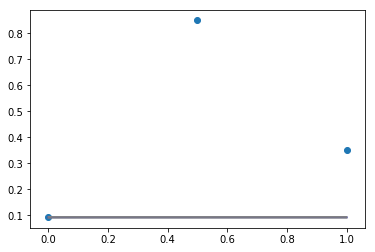

EPOCH 200, LOSS tensor([4.9423], grad_fn=<AddBackward0>)


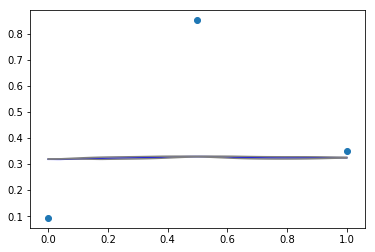

EPOCH 400, LOSS tensor([3.0624], grad_fn=<AddBackward0>)


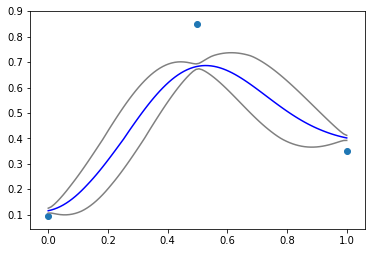

EPOCH 600, LOSS tensor([1.0106], grad_fn=<AddBackward0>)


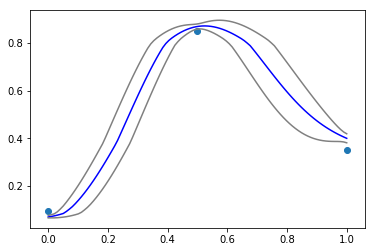

EPOCH 800, LOSS tensor([-0.0571], grad_fn=<AddBackward0>)


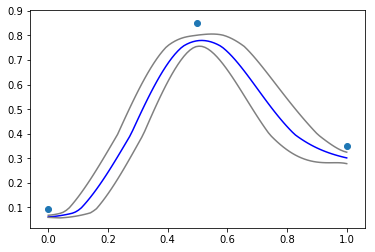

EPOCH 1000, LOSS tensor([0.2403], grad_fn=<AddBackward0>)


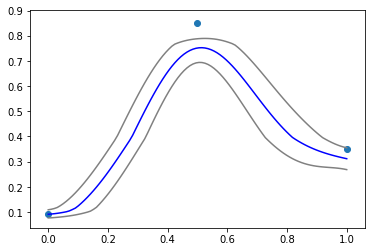

EPOCH 1200, LOSS tensor([0.4382], grad_fn=<AddBackward0>)


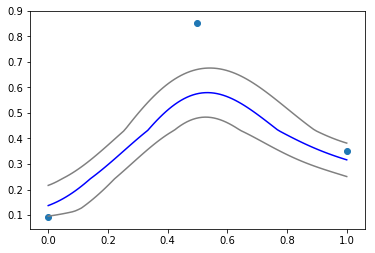

EPOCH 1400, LOSS tensor([0.2595], grad_fn=<AddBackward0>)


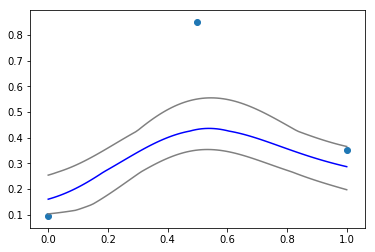

EPOCH 1600, LOSS tensor([-0.0486], grad_fn=<AddBackward0>)


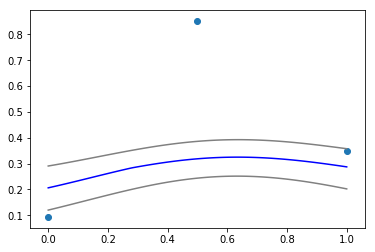

EPOCH 1800, LOSS tensor([0.2282], grad_fn=<AddBackward0>)


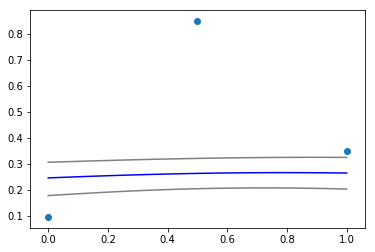

In [173]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = RegressionVAE(1, 1, 10, 1, likelihood, xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, 2000, 0.0, optimizer)

EPOCH 0, LOSS tensor([20.0052], grad_fn=<AddBackward0>)


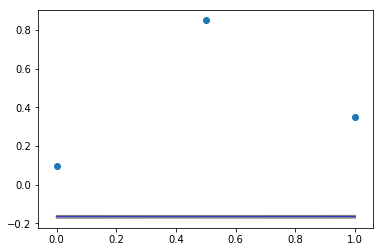

EPOCH 200, LOSS tensor([5.1300], grad_fn=<AddBackward0>)


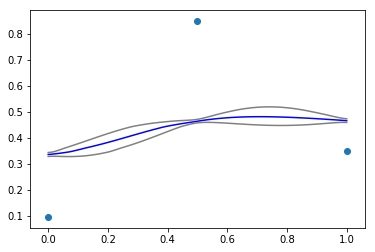

EPOCH 400, LOSS tensor([0.9051], grad_fn=<AddBackward0>)


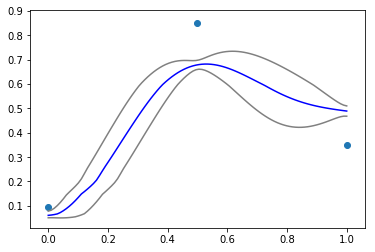

EPOCH 600, LOSS tensor([-0.1228], grad_fn=<AddBackward0>)


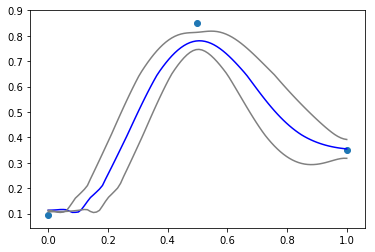

EPOCH 800, LOSS tensor([-0.2947], grad_fn=<AddBackward0>)


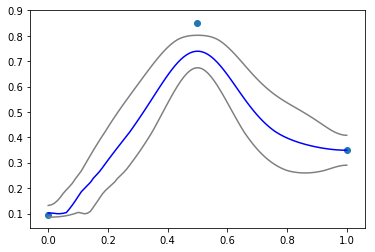

EPOCH 1000, LOSS tensor([-0.8856], grad_fn=<AddBackward0>)


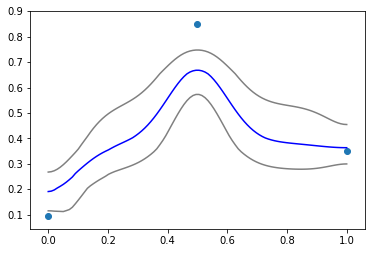

EPOCH 1200, LOSS tensor([-0.6970], grad_fn=<AddBackward0>)


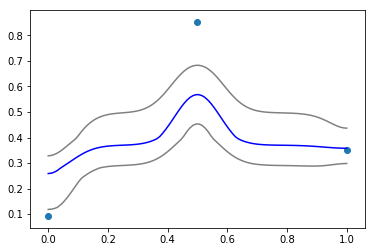

EPOCH 1400, LOSS tensor([-0.4504], grad_fn=<AddBackward0>)


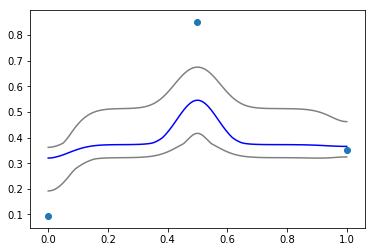

EPOCH 1600, LOSS tensor([-0.3641], grad_fn=<AddBackward0>)


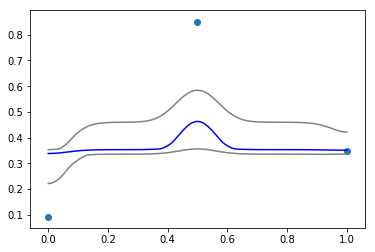

EPOCH 1800, LOSS tensor([-0.3749], grad_fn=<AddBackward0>)


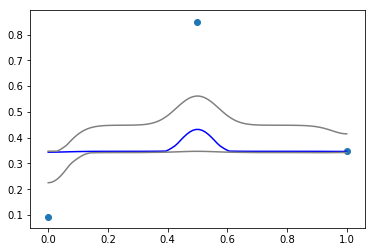

In [174]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = RegressionVAE(1, 1, 10, 1, likelihood, xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, 2000, 0.2, optimizer)

EPOCH 0, LOSS tensor([21.9742], grad_fn=<AddBackward0>)


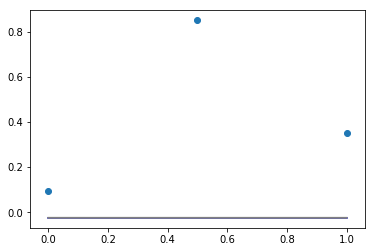

EPOCH 200, LOSS tensor([6.9726], grad_fn=<AddBackward0>)


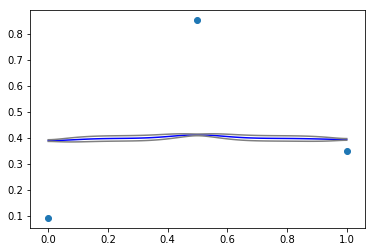

EPOCH 400, LOSS tensor([0.1568], grad_fn=<AddBackward0>)


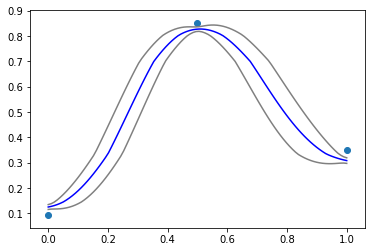

EPOCH 600, LOSS tensor([-1.6666], grad_fn=<AddBackward0>)


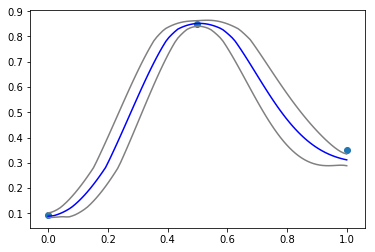

EPOCH 800, LOSS tensor([-1.5016], grad_fn=<AddBackward0>)


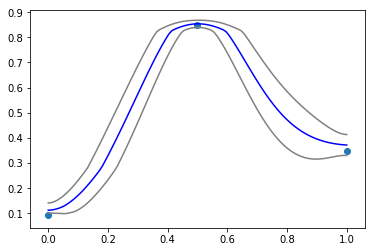

EPOCH 1000, LOSS tensor([-1.5349], grad_fn=<AddBackward0>)


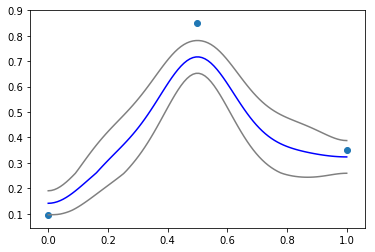

EPOCH 1200, LOSS tensor([-1.1959], grad_fn=<AddBackward0>)


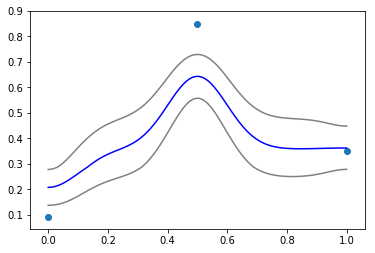

EPOCH 1400, LOSS tensor([-1.5808], grad_fn=<AddBackward0>)


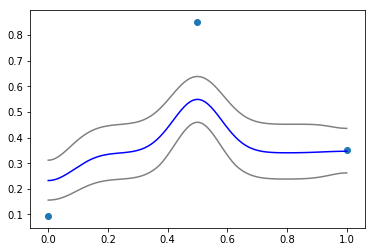

EPOCH 1600, LOSS tensor([-1.6122], grad_fn=<AddBackward0>)


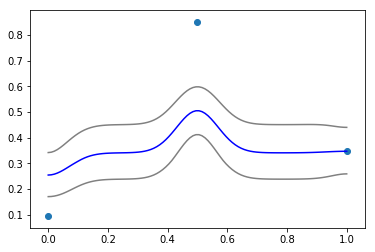

EPOCH 1800, LOSS tensor([-1.3828], grad_fn=<AddBackward0>)


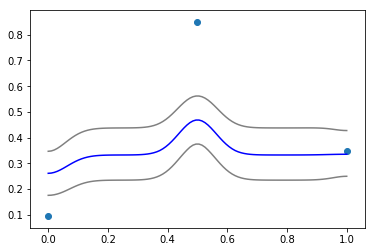

In [175]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = RegressionVAE(1, 1, 10, 1, likelihood, xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, 2000, 0.4, optimizer)

EPOCH 0, LOSS tensor([88.7953], grad_fn=<AddBackward0>)


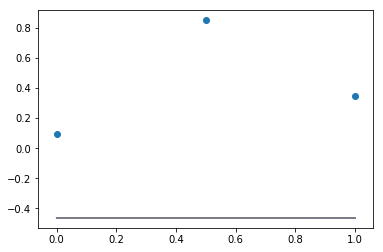

EPOCH 200, LOSS tensor([6.3517], grad_fn=<AddBackward0>)


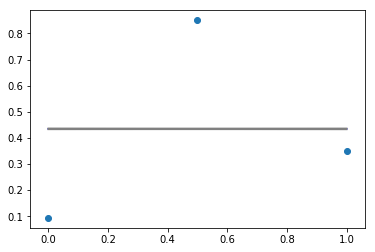

EPOCH 400, LOSS tensor([0.6158], grad_fn=<AddBackward0>)


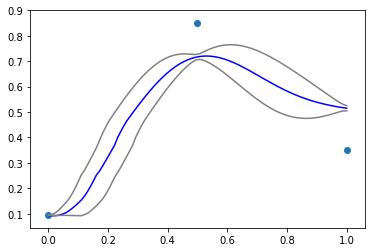

EPOCH 600, LOSS tensor([-2.5459], grad_fn=<AddBackward0>)


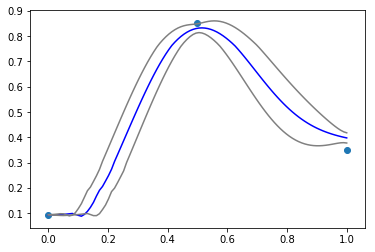

EPOCH 800, LOSS tensor([-2.4262], grad_fn=<AddBackward0>)


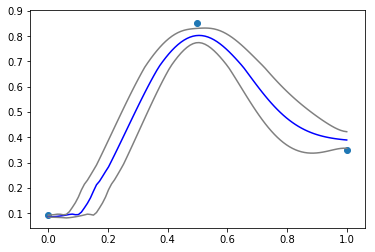

EPOCH 1000, LOSS tensor([-2.4540], grad_fn=<AddBackward0>)


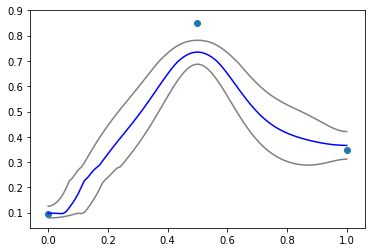

EPOCH 1200, LOSS tensor([-2.3070], grad_fn=<AddBackward0>)


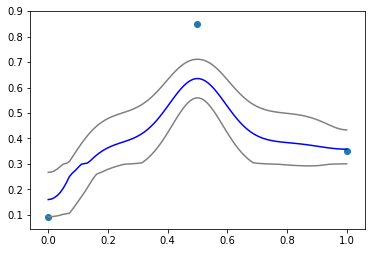

EPOCH 1400, LOSS tensor([-2.4013], grad_fn=<AddBackward0>)


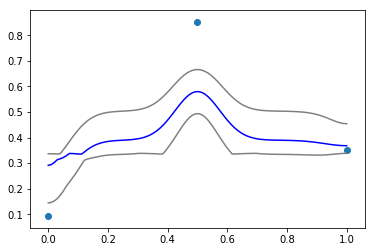

EPOCH 1600, LOSS tensor([-2.5643], grad_fn=<AddBackward0>)


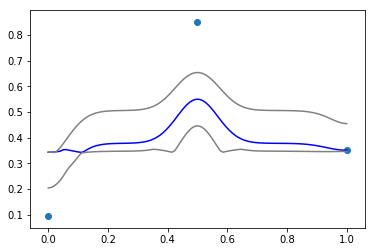

EPOCH 1800, LOSS tensor([-2.4795], grad_fn=<AddBackward0>)


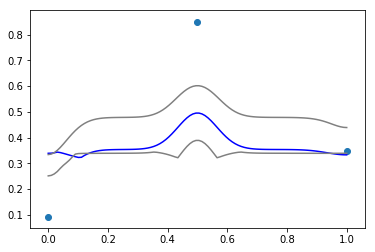

In [176]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = RegressionVAE(1, 1, 10, 1, likelihood, xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, 2000, 0.6, optimizer)

EPOCH 0, LOSS tensor([66.4283], grad_fn=<AddBackward0>)


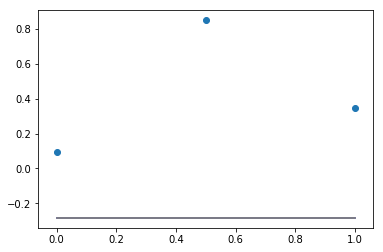

EPOCH 200, LOSS tensor([8.0918], grad_fn=<AddBackward0>)


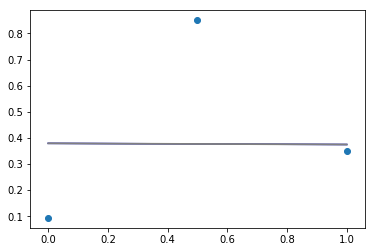

EPOCH 400, LOSS tensor([9.0222], grad_fn=<AddBackward0>)


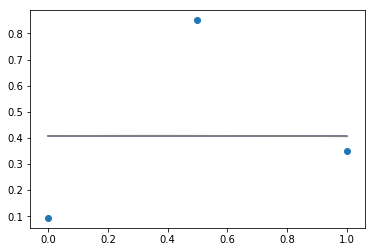

EPOCH 600, LOSS tensor([9.6357], grad_fn=<AddBackward0>)


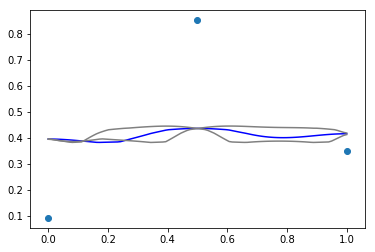

EPOCH 800, LOSS tensor([0.8508], grad_fn=<AddBackward0>)


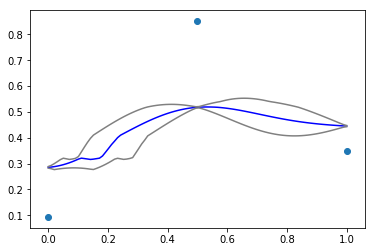

EPOCH 1000, LOSS tensor([5.1592], grad_fn=<AddBackward0>)


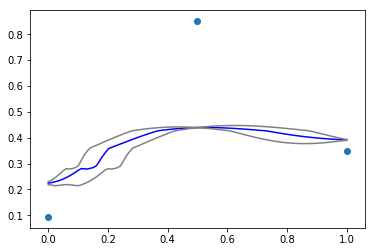

EPOCH 1200, LOSS tensor([0.5083], grad_fn=<AddBackward0>)


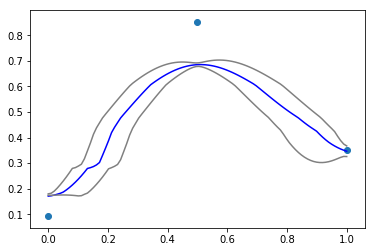

EPOCH 1400, LOSS tensor([-1.3087], grad_fn=<AddBackward0>)


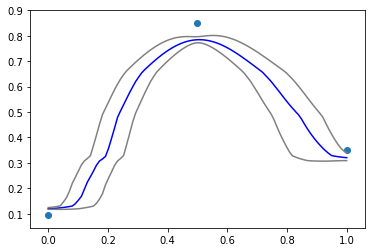

EPOCH 1600, LOSS tensor([-2.8542], grad_fn=<AddBackward0>)


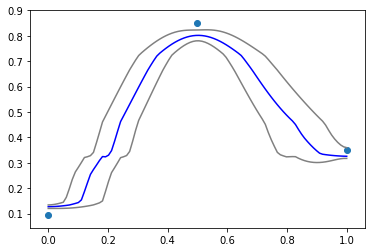

EPOCH 1800, LOSS tensor([-3.0550], grad_fn=<AddBackward0>)


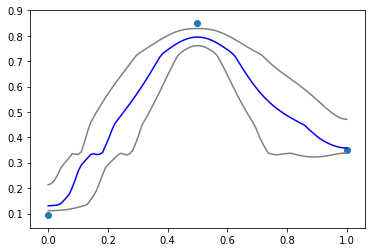

In [177]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = RegressionVAE(1, 1, 10, 1, likelihood, xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, 2000, 0.8, optimizer)

EPOCH 0, LOSS tensor([27.1218], grad_fn=<AddBackward0>)


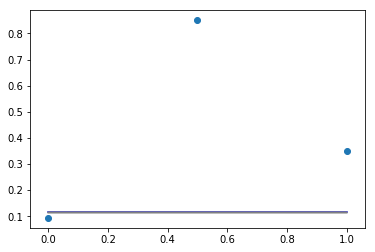

EPOCH 200, LOSS tensor([9.8761], grad_fn=<AddBackward0>)


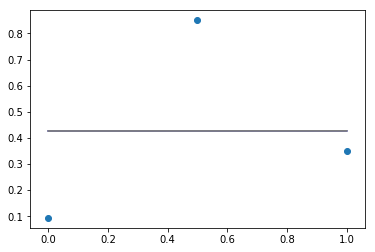

EPOCH 400, LOSS tensor([8.5223], grad_fn=<AddBackward0>)


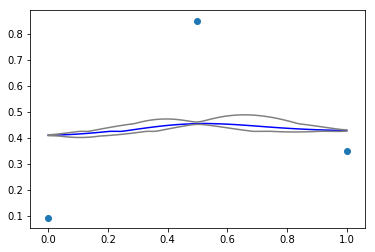

EPOCH 600, LOSS tensor([-3.5227], grad_fn=<AddBackward0>)


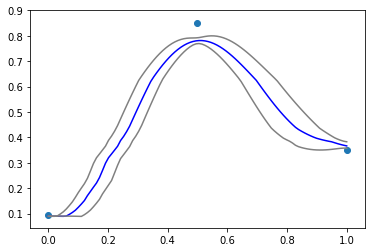

EPOCH 800, LOSS tensor([-3.7849], grad_fn=<AddBackward0>)


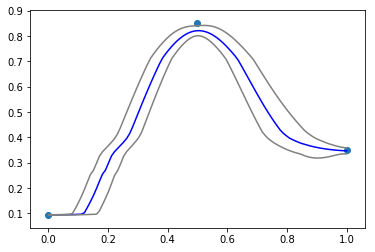

EPOCH 1000, LOSS tensor([-4.0548], grad_fn=<AddBackward0>)


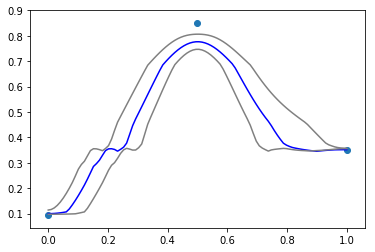

EPOCH 1200, LOSS tensor([-4.0302], grad_fn=<AddBackward0>)


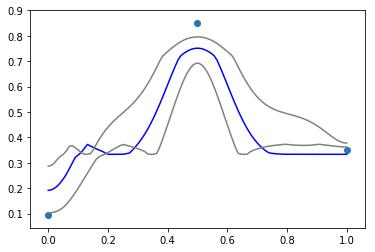

EPOCH 1400, LOSS tensor([-4.1016], grad_fn=<AddBackward0>)


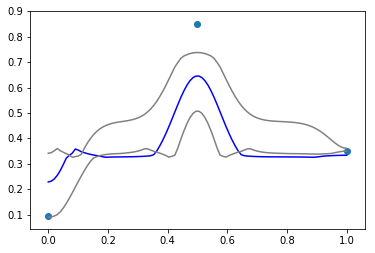

EPOCH 1600, LOSS tensor([-3.8604], grad_fn=<AddBackward0>)


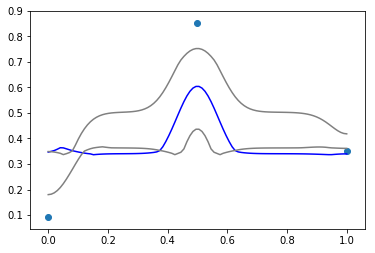

EPOCH 1800, LOSS tensor([-4.1429], grad_fn=<AddBackward0>)


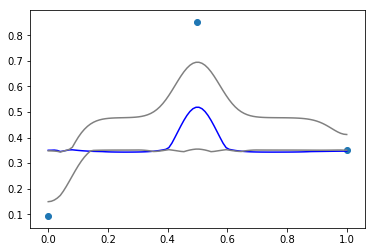

In [178]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = RegressionVAE(1, 1, 10, 1, likelihood, xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, 2000, 1.0, optimizer)